# Localized analysis: band-pass filtering, Hilbert transform

In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import xrft

import sstats.hfreq as hf
import sstats.tseries as ts
from sstats import get_cmap_colors

print_figs = True

---

## utils

In [2]:
def bpass_filter(omega,
                 domega, 
                 numtaps=10*24, 
                 dt=1./24.,
                 ftype='firwin2',
                ):
    ''' Wrapper around scipy.signal.firwing
    dt: float
        days
    omega: float
        cpd
    '''
    #
    if ftype=='firwin':
        h = signal.firwin(numtaps, 
                          cutoff=[omega-domega, omega+domega], 
                          pass_zero=False,
                          fs=1./dt, 
                          scale=True,
                         )
    elif ftype=='firwin2':
        h = signal.firwin2(numtaps, 
                           [0, omega-domega, omega-domega*0.5, omega+domega*0.5, omega+domega, 1./2/dt], 
                           [0, 0, 1, 1, 0, 0],
                           fs=1./dt,
                          )
    #
    t = np.arange(numtaps)*dt
    return h, t
        
def filter_response(h, dt=1./24.):
    ''' Returns the frequency response
    '''
    w, h_hat = signal.freqz(h, worN=8000, fs=1/dt)
    #return h_hat, (w/np.pi)/2/dt
    return h_hat, w


def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1)
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

## filter design: firwin vs firwin2

Should probably include alternatives (equivalent to harmonic analysis over a fixed window)

[Link to scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#filter-design)

In [3]:
sigma = 2.
domega = .3

F = {}
for f in ['firwin', 'firwin2']:
    
    h, t  = bpass_filter(sigma, domega, ftype=f)
    h_hat, w = filter_response(h)
    
    F[f] = dict(h=h, t=t, h_hat=h_hat, w=w, domega=domega, sigma=sigma)    

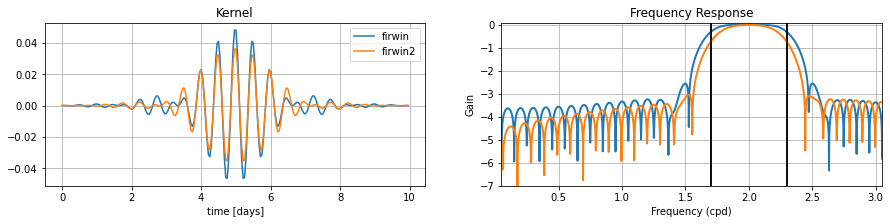

In [4]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
for ftype, f  in F.items():
    ax.plot(f['t'], f['h'], label=ftype)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
for ftype, f  in F.items():
    ax.plot(f['w'], np.log10(abs(f['h_hat'])), linewidth=2, label=ftype)
    ax.axvline(f['sigma']-f['domega'], color='k')
    ax.axvline(f['sigma']+f['domega'], color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

### sensitivity to kernel length

with firwin

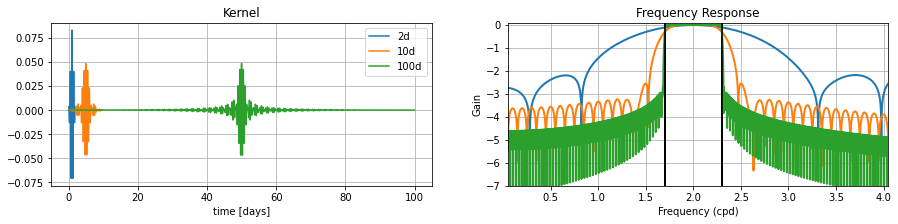

In [5]:
sigma = 2.
domega = .3

N = [2*24, 10*24, 100*24]

FN = {}
for n in N:
    
    h, t  = bpass_filter(sigma, domega, numtaps=n, ftype='firwin')
    h_hat, w = filter_response(h)
    
    FN[n] = dict(h=h, t=t, h_hat=h_hat, w=w, domega=domega, sigma=sigma)    
    
#
    
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
for n, f  in FN.items():
    ax.plot(f['t'], f['h'], label="{:d}d".format(int(n/24)))
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
for n, f  in FN.items():
    ax.plot(f['w'], np.log10(abs(f['h_hat'])), linewidth=2, label="{:d}d".format(int(n/24)))
    ax.axvline(f['sigma']-f['domega'], color='k')
    ax.axvline(f['sigma']+f['domega'], color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 4.05)
#ax.set_xlim(1.5, 2.5)
ax.grid(True)

## low-frequency signal

- theoretical output amplitude for an ideal band-pass filter
- illustrative example

How much energy is left after band-pass filtering

In [6]:
u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()

- filter bandwidth = $2\delta_\omega$
- U = signal amplitude (standard deviation)
- $T$ = signal decorrelation time scale (exponential autocorrelation)

In [7]:
delta = Symbol('delta_omega', positive=True)
T, sigma, U = u_low.p['T'], u_low.p['sigma'], u_low.p['U']
omega, tau = u_low.omega, u_low.tau

In [8]:
u_low.spectrum

2*T*U**2/(T**2*omega**2 + 1)

In [9]:
I_low = u_low.spectrum.integrate((omega, sigma-delta, sigma+delta)) *2  /2/pi
I_low = I_low.simplify()
E_low = lambdify([U, T, sigma, delta], I_low)
I_low

2*U**2*(atan(T*(delta_omega - sigma)) + atan(T*(delta_omega + sigma)))/pi

In [10]:
I_low.args

(2, 1/pi, U**2, atan(T*(delta_omega - sigma)) + atan(T*(delta_omega + sigma)))

In [11]:
# manually simplify the sum of arc tangents
# https://fr.wikipedia.org/wiki/Identité_trigonométrique
_x = I_low.args[3].args[0].args[0]
_y = -I_low.args[3].args[1].args[0]
_xy = (_x-_y)/(1+_x*_y)
_xy = _xy.func(*(factor(term) for term in _xy.args))

# hypothèse T x sigma > 1
I_low = I_low.args[0] * I_low.args[1] * atan(_xy)
E_low = lambdify([U, T, sigma, delta], I_low)
I_low

-2*atan(2*T*delta_omega/(T**2*delta_omega**2 - T**2*sigma**2 - 1))/pi

Limits when $\sigma T\gg 1$ (while $\delta_\omega < \sigma$) :

Here $T$ is the low-frequency signal decorrelation time scale, 
$\sigma$ the high-frequency signal frequency and $\delta_\omega$ a filtering half bandwidth.

In [12]:
low_proj = lambda U, T, sigma, delta, pi: U**2 * 4*delta/T/sigma**2 /pi
low_proj(U, T, sigma, delta, pi)

4*U**2*delta_omega/(pi*T*sigma**2)

In [13]:
# alternative route: start from approximated specrtum
T, U, sigma = u_low.p.values()
omega = u_low.omega
_E = 2*U**2/T/omega**2
_I = _E.integrate((omega, sigma-delta, sigma+delta)) *2  /2/pi
_I.simplify()

-4*U**2*delta_omega/(pi*T*(delta_omega - sigma)*(delta_omega + sigma))

#### Illustration

In [14]:
da = u_low.generate_tseries(time=(1000,1/24), tau=[2,5,10,20,40], seed=0).persist()

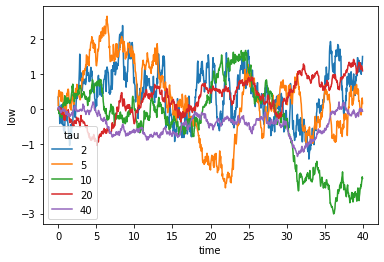

In [15]:
_ = da.where(da.time<40).plot.line(x='time')

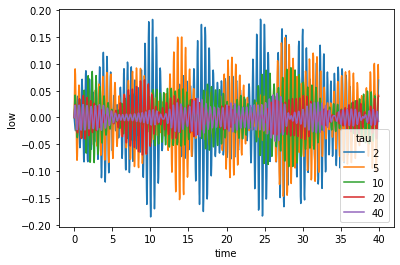

In [16]:
f = F['firwin']
da_filtered = filt(da, f['h'])
_ = da_filtered.where(da.time<40).plot.line(x='time')

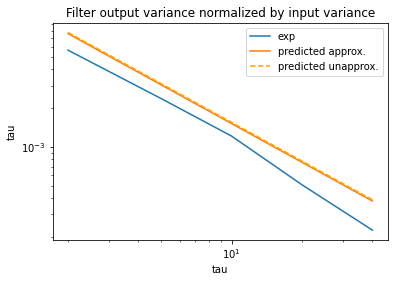

In [17]:
ax = plt.subplot(111)
(da_filtered.var('time')/da.var('time') ).plot(ax=ax, label='exp')

# sigma is converted only once to rad/d because of the ratio delta_omega/sigma
#r = 4*f['domega']/(np.pi*da.tau*2*np.pi*f['sigma']**2)
r = low_proj(1., da.tau, 2*np.pi*f['sigma'], 2*np.pi*f['domega'], np.pi)
r.plot(ax=ax, label='predicted approx.')
rbis = E_low(1., da.tau, 2*np.pi*f['sigma'], 2*np.pi*f['domega'])
rbis.plot(ax=ax, label='predicted unapprox.', color='orange', ls='--')

#ax.axhline(1e-3, color='k')
ax.legend()
ax.set_title('Filter output variance normalized by input variance')

ax.set_xscale("log")
ax.set_yscale("log")

**Conclusion**: the variance that leaks out varies as $U^2 \times 4\delta_\omega/(\pi T\sigma^2)$.

It varies linearly with filter bandwidth, inversely with the slow-signal decorrelation time scale and inversely with the square of the high-frequency signal frequency.

## high-frequency signal

- theoretical output amplitude for an ideal band-pass filter
- illustrative example

Parameters of the problem are:
- U = signal amplitude (standard deviation)
- $\sigma$: signal frequency and band-pass filter central frequency
- $T$ = signal decorrelation time scale (exponential autocorrelation of the enveloppe)
- filter bandwidth = $2\delta_\omega$

In [18]:
I_high = u_high.spectrum.integrate((omega, sigma-delta, sigma+delta)) *2  /2/pi
I_high = I_high.simplify()
E_high = lambdify([U, T, sigma, delta], I_high)
I_high

U**2*(atan(T*(delta_omega - sigma)/2) + atan(T*(delta_omega + sigma)/2) + atan(T*(delta_omega - sigma)*(-T**2*sigma**2 + T**2*(delta_omega - sigma)**2 + 3)/(2*(T**2*sigma**2 + 1))) + atan(T*(delta_omega + sigma)*(-T**2*sigma**2 + T**2*(delta_omega + sigma)**2 + 3)/(2*(T**2*sigma**2 + 1))))/pi

In [19]:
# normalize parameters
s = Symbol('s', positive=True)
d = Symbol('d', positive=True)
I_high_norm = I_high.subs({sigma:s/T, delta:d/T}).simplify()
E_high_norm = lambdify([U, s, d], I_high_norm)
I_high_norm

U**2*(atan((d - s)*(-s**2 + (d - s)**2 + 3)/(2*(s**2 + 1))) + atan((d + s)*(-s**2 + (d + s)**2 + 3)/(2*(s**2 + 1))) + atan(d/2 - s/2) + atan(d/2 + s/2))/pi

In [25]:
_delta = np.linspace(0, 2., 100)
_s = [1, 10, 20]
ds = xr.Dataset(None, coords={'delta': (['delta'], _delta),
                              'sigma': (['sigma'], _s)},)
ds['E'] = E_high_norm(1., 2*np.pi*ds.sigma, 2*np.pi*ds.delta)
ds['E'] = ds['E'].where(ds.delta<=ds.sigma)

Text(0.5, 1.0, 'Fraction of output variance recovered')

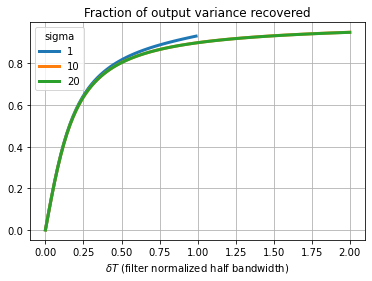

In [27]:
ax = plt.subplot(111)
ds.E.plot.line(x='delta', ax=ax, lw=3)
ax.grid()
#ax.set_ylim(0,1)
ax.set_ylabel("")
ax.set_xlabel(r'$\delta T$ (filter normalized half bandwidth)')
ax.set_title('Fraction of output variance recovered')

**Conclusion:** assuming an ideal band-pass filter, 90% of the total variance is recovered if the filter bandwidth is $2/T$ (see `high.ipynb` for values with other autocorrelation shapes). 
Any departure from an ideal filter may require larger bandwidths

A filter should at least be of width $1/T$, but $T$ is partially unknown in practice.
So we'd like to the filter to be wider.
This may however lead to projection of the low frequency signal.

The variance of a sum signal is (assuming $\delta_\omega T_{high} > 1$):

$
\begin{align}
U_{sum}^2 = 
U_{low}^2 \times 4\delta_\omega/(\pi T_{low}\sigma^2)
+
U_{high}^2
\end{align}
$

We'd like the cross-projection to stay below a $\epsilon$ threshold (for example 10\%):

$
\begin{align}
\delta_\omega
&< \sigma \times \epsilon \frac{\pi T_{low}\sigma}{4} \frac{U_{high}^2}{U_{low}^2}
\end{align}
$

Recollecting the lower bound assumed on $\delta_\omega$, such filtering is only possible if:

$
\begin{align}
\epsilon 
\times (T_{high}\sigma)
\times (T_{low}\sigma) 
>
\frac{4}{\pi} \frac{U_{low}^2}{U_{high}^2}
\end{align}
$

The later ratio can be used to diagnose a critical amplitude ratios, or time scale values

**An illustration would be welcome here:**
fix temporal scales and vary amplitude ratios.

For small ratios, 

What should we do in defavorable situations?

What's going on in the real ocean?

In [22]:
U_low = 1.
T_low = 10. # d
T_high = 10. # d
sigma = 1. # cpd
#epsilon = .1 # unitless

_delta = np.linspace(0, sigma, 100)
_u = [.01, .1, .5, 1.]
ds = xr.Dataset(None,
                coords={'delta': (['delta'], _delta),
                        'U_high': (['U_high'], _u),
                       },
               )

ds['E_high'] = E_high(ds.U_high, T_high, 2*np.pi*sigma, 2*np.pi*ds.delta)
ds['E_low'] = E_low(U_low, T_low, 2*np.pi*sigma, 2*np.pi*ds.delta)
ds['E'] = ds['E_high'] + ds['E_low']

Text(0.1, 2e-05, '$1/T_{high}$')

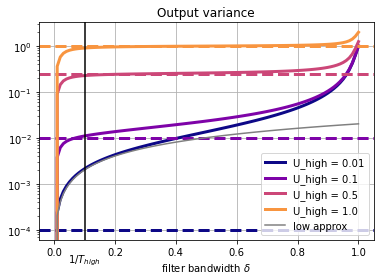

In [23]:
colors = get_cmap_colors(ds.U_high.size)

ax = plt.subplot(111)
for u, c in zip(ds.U_high, colors):
    ds.E.sel(U_high=u).plot.line(x='delta', ax=ax, lw=3, color=c, label="U_high = {}".format(float(u)))
    ax.axhline(u**2, color=c, ls='--', lw=3)

I_low_approx = U_low**2 * 4*ds.delta/(np.pi*T_low*sigma**2) /(2*np.pi)
I_low_approx.plot(ax=ax, color='0.5', label='low approx')

ax.grid()
#ax.set_ylim(0,1)
#ax.set_xlabel('delta T (filter normalized bandwidth)')
ax.set_title('Output variance')
ax.set_xlabel('filter bandwidth $\delta$')
ax.set_ylabel('')
ax.set_yscale('log')
ax.axvline(1/T_high, color='k')
ax.legend()
ax.text(1/T_high,2*1e-5,r'$1/T_{high}$', rotation=0, ha="center")

In [24]:
# compute spectra
ds = ds.assign_coords(omega=("omega", np.arange(1/100, 12, 1/100)))
ds['spectrum_low'] = u_low.evaluate_spectrum(omega=ds.omega, T=T_low, U=U_low)
ds['spectrum_high'] = u_high.evaluate_spectrum(omega=ds.omega, T=T_high, U=ds.U_high, sigma=sigma)
ds['spectrum'] = ds['spectrum_low'] + ds['spectrum_high']

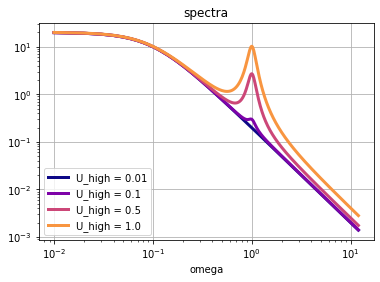

In [25]:
ax = plt.subplot(111)
for u, c in zip(ds.U_high, colors):
    ds.spectrum.sel(U_high=u).plot.line(x='omega', ax=ax, lw=3, color=c, label="U_high = {}".format(float(u)))
    #ax.axhline(u**2, color=c, ls='--', lw=3)
ax.grid()
ax.set_title('spectra')
#ax.set_xlabel('filter bandwidth $\delta$')
ax.set_ylabel('')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

---

## Hilbert transform

### apply band-passed filter and hilbert transform

In [26]:
# generate synthetic data

def rename_attrs(da, **kwargs):
    """ rename attributes
    """
    for k_new, k_old in kwargs.items():
        da = da.assign_attrs(**{k_new: da.attrs.pop(k_old)})
    return da

# high
da_high = (u_high
           .generate_tseries(time=(1000, 1/24), 
                             T=10.,
                             sigma=2.,
                             rms=[0.01, .1, 1.], 
                             seed=0,
                            )
           .persist()
          )
da_high = (rename_attrs(da_high, T_high="tau")
           .rename(rms='U_high')
          )
# low:
da_low = (u_low.generate_tseries(time=(1000, 1/24), 
                                 T=10., 
                                 rms=1., 
                                 seed=0,
                                )
            ).persist()
da_low = rename_attrs(da_low, T_low="tau", U_low="rms")

ds = xr.merge([da_high, da_low], combine_attrs="no_conflicts")

In [27]:
# wrapper

def bpass_hilbert(ds, sigma, domega):
    h, t  = bpass_filter(sigma, domega, numtaps=100*24, ftype="firwin")
    h_hat, w = filter_response(h)
    
    exp = np.exp(-1j*2*np.pi*sigma*ds["time"])
    for v in ds:
        ds[v+'_bpassed'] = filt(ds[v], h, hilbert=True).persist()
        ds[v+'_demodulated'] = ds[v+'_bpassed']*exp
    ds['exp'] = exp
    
    return ds, h, h_hat, w

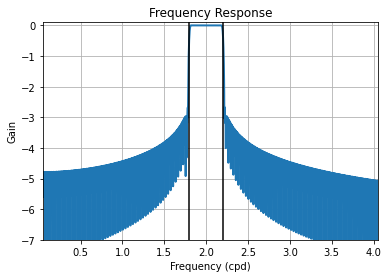

In [28]:
sigma = ds.sigma
domega = 2/ds.T_high

ds, h, h_hat, w = bpass_hilbert(ds, sigma, domega)

fig, ax = plt.subplots(1,1)

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(sigma-domega, color='k')
ax.axvline(sigma+domega, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 4.05)
#ax.set_xlim(1.5, 2.5)
ax.grid(True)

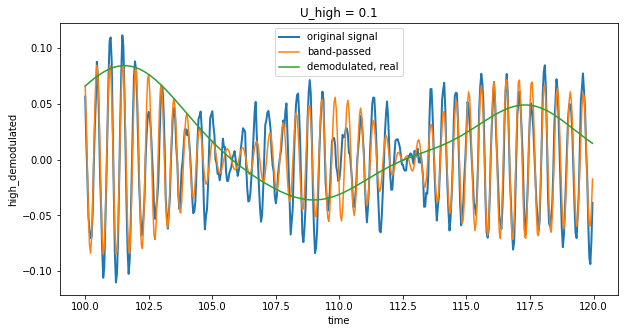

In [29]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
_ds = ds.sel(U_high=.1).where( (da.time>=100) & (da.time<120) )
np.real(_ds["high"]).plot.line(x='time', lw=2, label="original signal")
np.real(_ds["high_bpassed"]).plot.line(x='time', label="band-passed")
np.real(_ds["high_demodulated"]).plot.line(x='time', label="demodulated, real")
plt.legend()

In [30]:
# variance of the residual
diff_high = _ds["high"] - np.real(_ds["high_bpassed"])
print("Residual variance = {:.2e}'".format(float(diff_high.var()/_ds["high"].var())))

Residual variance = 1.68e-01'


### inspect with spectra: high, high_bpassed, residual

Original variance:
[5.19548803e-05 5.44471376e-03 5.07620953e-01]
From spectra:
[4.91112427e-05 5.24884108e-03 5.02025006e-01]
Ratio (spectra/original):
[0.94526717 0.96402516 0.98897613]


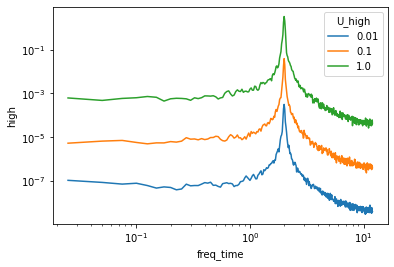

In [31]:
def get_spectrum(da):
    ps = (xrft
          .power_spectrum(da.chunk({"time": 24*40}), 
                          dim=["time"],
                          chunks_to_segments=True,
                          window="hann",
                          window_correction=True,
                         )
          .mean("time_segment")
          .rename(da.name)
          .persist()
         )
    return ps

v="high"
ps = get_spectrum(ds[v])
ps.where(ps.freq_time>0).plot.line(x="freq_time", xscale='log', yscale='log')

# check Parseval:
print("Original variance:")
var_original = ds[v].var("time").values
print(var_original )
print("From spectra:")
var_spectra = np.trapz(ps.values, ps.freq_time.values)
print(var_spectra)
print("Ratio (spectra/original):")
print(var_spectra/var_original)

In [32]:
spectra = xr.merge([get_spectrum(np.real(ds[v])) for v in ds]
                   +[get_spectrum((ds[v]-np.real(ds[v+"_bpassed"])).rename(v+"_diff")) 
                     for v in ["high", "low"]
                    ],
                  )

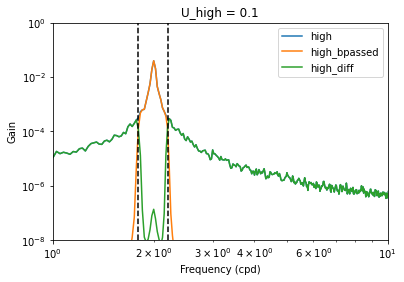

In [33]:
v = "high"

_ds = spectra.sel(U_high=0.1).where(spectra.freq_time>0)

fig, ax = plt.subplots(1,1) # figsize=(15,3)

k = dict(x="freq_time", xscale='log', yscale='log', ax=ax)
_ds[v].plot.line(label=v, **k)
_ds[v+"_bpassed"].plot.line(label=v+"_bpassed", **k)
_ds[v+"_diff"].plot.line(label=v+"_diff", **k)

ax.axvline(sigma-domega, color='k', ls='--')
ax.axvline(sigma+domega, color='k', ls='--')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_xlim(1e0, 1e1)
ax.set_ylim(1e-8, 1e0)
ax.legend()

### focus on the enveloppe 

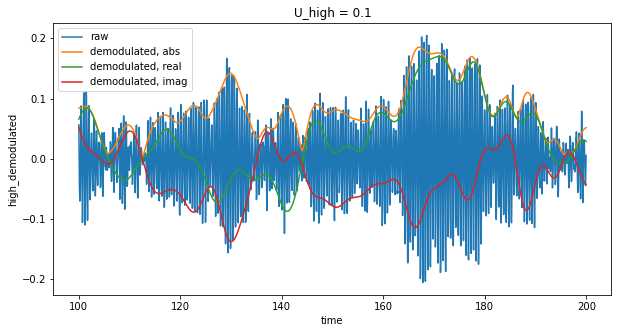

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
_ds = ds.sel(U_high=.1).where( (da.time>=100) & (da.time<200) )
_ds["high"].plot.line(x='time', label="raw")
np.abs(_ds["high_demodulated"]).plot.line(x='time', label="demodulated, abs")
np.real(_ds["high_demodulated"]).plot.line(x='time', label="demodulated, real")
np.imag(_ds["high_demodulated"]).plot.line(x='time', label="demodulated, imag")
plt.legend()

In [35]:
# check phase of synthetic signal
#np.abs(_ds["high_demodulated"]).plot.line(x='time', label="demodulated, real")
#xr.apply_ufunc(np.angle, _ds["high_demodulated"], dask="parallelized").plot.line(x='time', label="demodulated, real")

### sentivity to the filter bandwidth

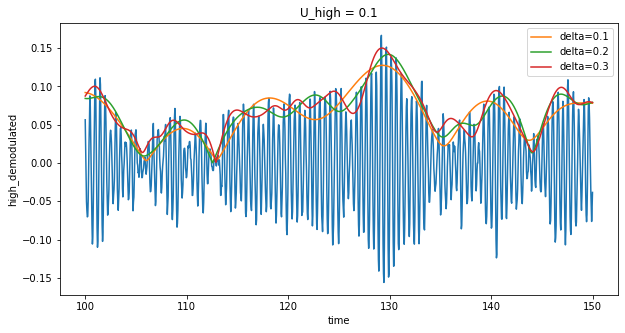

In [36]:
fig, ax = plt.subplots(1,1, figsize=(10,5))

_ds = ds.sel(U_high=.1).where( (da.time>=100) & (da.time<150) )
_ds["high"].plot.line(x='time')

for domega in [1/T_high, 2/T_high, 3/T_high]:
    ds, h, h_hat, w = bpass_hilbert(ds[["high", "low"]], sigma, domega)
    _ds = ds.sel(U_high=.1).where( (da.time>=100) & (da.time<150) )
    np.abs(_ds["high_demodulated"]).plot.line(x='time', label="delta={}".format(domega))
plt.legend()

### autocorrelations of the enveloppe

In [37]:
domega = 1/T_high
ds, h, h_hat, w = bpass_hilbert(ds[["high", "low"]], sigma, domega)

In [38]:
def autocorrelations(ds, combine=False):
    V = ["high", "low"]
    if combine:
        ds["sum"] = ds["high"]  + ds["low"]
        ds["sum_demodulated"] = ds["high_demodulated"]  + ds["low_demodulated"]
        V = V + ["sum"]
    R = []
    for v in V:
        R.append((ts
                  .correlate(ds[v+"_demodulated"], ds[v+"_demodulated"])
                  .rename(v)
                  .to_dataset()
                  .rename({'lags': 'tau'})
                 )
                )
    return xr.merge(R)

R = autocorrelations(ds)
#R

(0.0, 300.0)

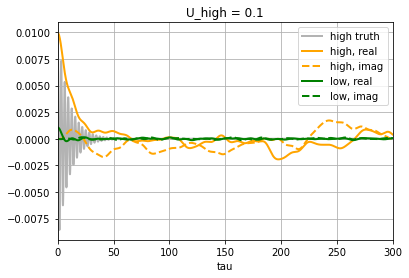

In [39]:
_ds = R.sel(U_high=0.1)

_ds['high_true'] = u_high.evaluate_autocorrelation(U=_ds.U_high, sigma=sigma, T=T_high, tau=_ds.tau)

fig, ax = plt.subplots(1,1)
_ds['high_true'].plot.line(x='tau', ax=ax, color='0.7', lw=2, label='high truth')
np.real(_ds['high']).plot.line(x='tau', ax=ax, color='orange', lw=2, label='high, real')
np.imag(_ds['high']).plot.line(x='tau', ax=ax, color='orange', lw=2, ls='--', label='high, imag')
np.real(_ds['low']).plot.line(x='tau', ax=ax, color='green', lw=2, label='low, real')
np.imag(_ds['low']).plot.line(x='tau', ax=ax, color='green', lw=2, ls='--', label='low, imag')
ax.grid()
ax.legend()
ax.set_ylabel(None)
ax.set_xlim(0,300)

### sensibility to filter bandwidth

(0.0, 40.0)

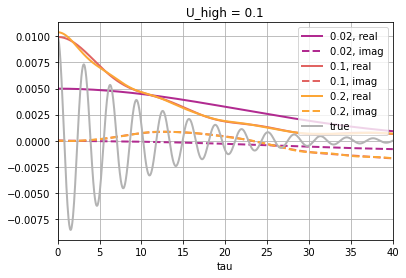

In [40]:
fig, ax = plt.subplots(1,1)

Domegas = [0.2/T_high, 1/T_high, 2/T_high]
colors = get_cmap_colors(len(Domegas)+2, cmap='plasma')

for domega, c in zip(Domegas, colors[2:]):
    
    ds, h, h_hat, w = bpass_hilbert(ds[["high", "low"]], sigma, domega)
    R = autocorrelations(ds)

    _ds = R.sel(U_high=0.1)
    
    np.real(_ds['high']).plot.line(x='tau', ax=ax, color=c, lw=2, label='{}, real'.format(domega))
    np.imag(_ds['high']).plot.line(x='tau', ax=ax, color=c, lw=2, ls='--', label='{}, imag'.format(domega))
    #_ds['low'].plot.line(x='tau', ax=ax, color='green', lw=2, label='low estimate')

_ds['high_true'] = u_high.evaluate_autocorrelation(U=_ds.U_high, sigma=sigma, T=T_high, tau=_ds.tau)
_ds['high_true'].plot.line(x='tau', ax=ax, color='0.7', lw=2, label='true')
    
ax.grid()
ax.legend(loc="upper right")
ax.set_ylabel(None)
ax.set_xlim(0,40)

### combined timeseries

In [41]:
domega = 2/T_high
ds, h, h_hat, w = bpass_hilbert(ds[["high", "low"]], sigma, domega)

R = autocorrelations(ds, combine=True)

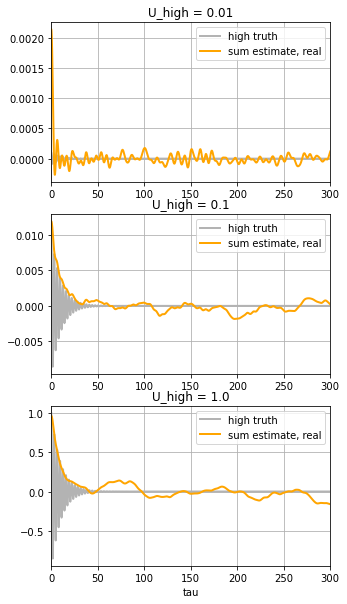

In [42]:
_u_high = R.U_high.values
fig, axes = plt.subplots(_u_high.size,1, figsize=(5,10))

for _u, ax in zip(_u_high, axes):

    _ds = R.sel(U_high=_u)
    
    _ds['high_true'] = u_high.evaluate_autocorrelation(U=_u, sigma=sigma, T=T_high, tau=_ds.tau)

    _ds['high_true'].plot.line(x='tau', ax=ax, color='0.7', lw=2, label='high truth')
    np.real(_ds['sum']).plot.line(x='tau', ax=ax, color='orange', lw=2, label='sum estimate, real')
    #_ds['low'].plot.line(x='tau', ax=ax, color='green', lw=2, label='low estimate')
    ax.grid()
    ax.legend()
    ax.set_ylabel(None)
    ax.set_xlim(0,300)
    if _u!=_u_high[-1]:
        ax.set_xlabel("")

## things remaining to be done, questions

- show impact of a low frequency contribution on the estimate of the lag, better synthesis
- illustrate stationary case? (issue with mean in autocorrelation computation)
- illustrate effect of neighbooring stationary frequencies
- sensitivity to filter kernel length?
- show statistical accuracy of the lag/variance estimate as a function of time window ?
- can the fast decorrelation of the band-passed low frequency enveloppes be leveraged when the high frequency signal exhibit a larger correlation? Can we quantify the decorrelation timescale of the band-passed low frequency enveloppe?